In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

## 1. Data Loading and Preparation

In [2]:
df = pd.read_csv('..\\data\\Crime_Data_from_2020_to_Present.csv')

# Standardize column names
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (1004847, 28)


,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


In [3]:
# Descent code mapping from the data dictionary
descent_code_dict = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean',
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    'Z': 'Asian Indian'
}

# Create a readable descent column
df['vict_descent_label'] = df['vict_descent'].map(descent_code_dict)

# Drop rows with null values in key analysis columns
rows_before = df.shape[0]
df = df.dropna(subset=['crm_cd_desc', 'date_occ', 'vict_descent', 'area_name', 'status_desc'])
rows_after = df.shape[0]
print(f'Rows dropped due to nulls in key columns: {rows_before - rows_after}')
print(f'Remaining rows: {rows_after}')

Rows dropped due to nulls in key columns: 144616
Remaining rows: 860231


In [4]:
# Convert date column
df['date_occ'] = pd.to_datetime(df['date_occ'])
df['year'] = df['date_occ'].dt.year

# Filter out 'Unknown' descent to focus on identified racial groups
df_known = df[df['vict_descent_label'] != 'Unknown'].copy()
print(f'Rows after excluding Unknown descent: {df_known.shape[0]}')

Rows after excluding Unknown descent: 753572


## 2. Demographic Distribution of Victims

Before looking for bias, we need to understand how the victim population is distributed across racial/ethnic groups. This gives us the baseline to compare against.

In [5]:
# Overall victim descent distribution
descent_counts = df_known['vict_descent_label'].value_counts()
descent_pct = df_known['vict_descent_label'].value_counts(normalize=True) * 100

descent_summary = pd.DataFrame({
    'count': descent_counts,
    'percentage': descent_pct.round(2)
})

print('Victim descent distribution:')
descent_summary

Victim descent distribution:


,count,percentage
vict_descent_label,,
Hispanic/Latin/Mexican,296365,39.33
White,201424,26.73
Black,135810,18.02
Other,77996,10.35
Other Asian,21336,2.83
Korean,5990,0.79
Filipino,4838,0.64
Chinese,4631,0.61
Japanese,1586,0.21


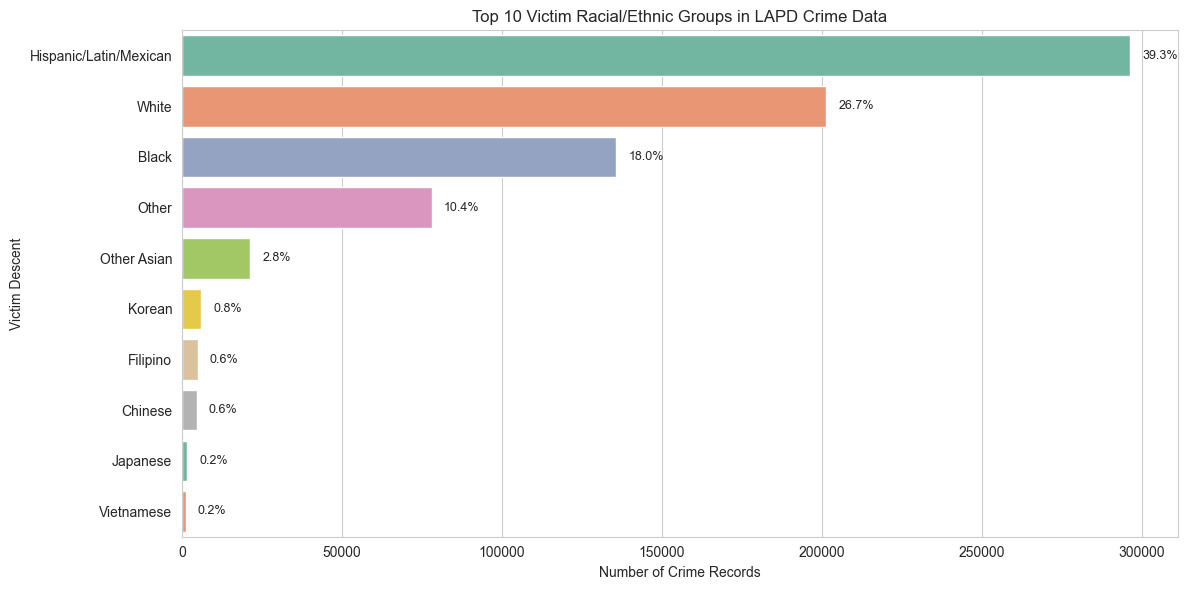

In [6]:
# Visualize victim distribution for the most represented groups
top_descents = descent_counts.head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_descents.values, y=top_descents.index, palette='Set2')
plt.xlabel('Number of Crime Records')
plt.ylabel('Victim Descent')
plt.title('Top 10 Victim Racial/Ethnic Groups in LAPD Crime Data')

# Add percentage labels
total = descent_counts.sum()
for i, v in enumerate(top_descents.values):
    ax.text(v + total * 0.005, i, f'{v/total*100:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Crime Type Distribution by Racial Group

We compare the types of crimes reported for each major racial group. If crime types differ substantially between groups, it could indicate reporting bias, policing patterns, or socioeconomic factors.

In [7]:
# Select the 5 largest descent groups for focused comparison
top_5_groups = df_known['vict_descent_label'].value_counts().head(5).index.tolist()
df_top5 = df_known[df_known['vict_descent_label'].isin(top_5_groups)].copy()

print(f'Top 5 descent groups: {top_5_groups}')
print(f'Records in top 5 groups: {df_top5.shape[0]}')

Top 5 descent groups: ['Hispanic/Latin/Mexican', 'White', 'Black', 'Other', 'Other Asian']
Records in top 5 groups: 732931


In [8]:
# For each of the top 5 groups, compute the top 10 crime types as a proportion
crime_profiles = {}

for group in top_5_groups:
    group_data = df_top5[df_top5['vict_descent_label'] == group]
    crime_profiles[group] = group_data['crm_cd_desc'].value_counts(normalize=True).head(10)

# Build a comparison table with the top 10 crimes overall
top_10_crimes = df_top5['crm_cd_desc'].value_counts().head(10).index

comparison = pd.DataFrame()
for group in top_5_groups:
    group_data = df_top5[df_top5['vict_descent_label'] == group]
    proportions = group_data['crm_cd_desc'].value_counts(normalize=True)
    comparison[group] = proportions.reindex(top_10_crimes).fillna(0) * 100

comparison = comparison.round(2)
print('Crime type proportions (%) for top 5 descent groups, using the 10 most common crime types:')
comparison

Crime type proportions (%) for top 5 descent groups, using the 10 most common crime types:


,Hispanic/Latin/Mexican,White,Black,Other,Other Asian
crm_cd_desc,,,,,
BATTERY - SIMPLE ASSAULT,12.67,6.86,10.80,7.61,8.97
THEFT OF IDENTITY,6.75,8.85,10.35,7.10,5.45
BURGLARY FROM VEHICLE,6.51,10.15,6.58,8.60,9.53
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",8.98,3.63,10.63,3.54,3.67
"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",6.20,6.64,5.83,7.64,5.88
INTIMATE PARTNER - SIMPLE ASSAULT,8.32,3.54,8.41,2.99,4.07
THEFT PLAIN - PETTY ($950 & UNDER),4.34,8.32,5.49,7.19,7.80
BURGLARY,2.95,8.78,3.65,11.30,13.72
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER),4.14,6.72,2.14,4.29,4.65


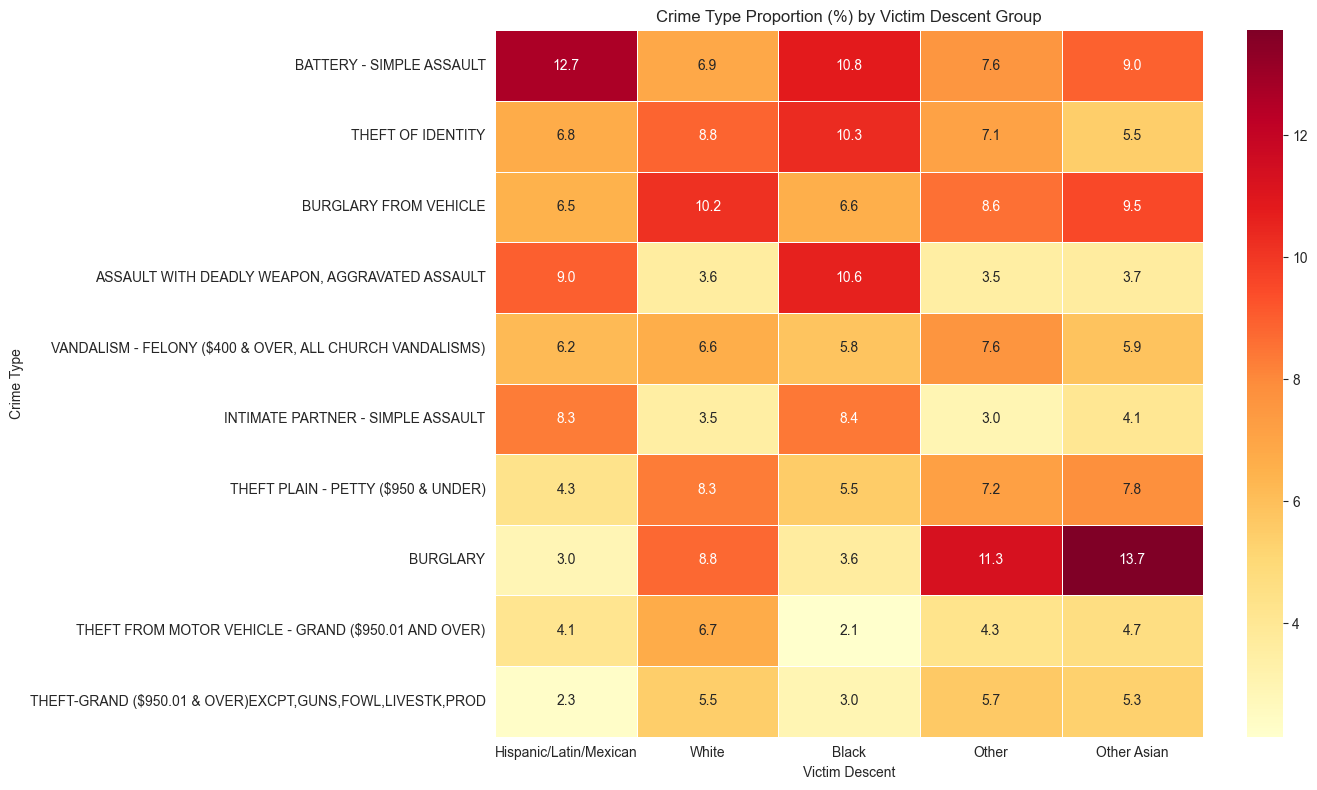

In [9]:
# Heatmap of crime type proportions by descent group
plt.figure(figsize=(14, 8))
sns.heatmap(comparison, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('Crime Type Proportion (%) by Victim Descent Group')
plt.xlabel('Victim Descent')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

## 4. Case Resolution Disparity

A key indicator of potential systemic bias is whether cases are resolved at different rates depending on the victim's race. We examine the case status distribution across racial groups.

In [10]:
# Case status distribution per descent group
status_by_descent = df_top5.groupby('vict_descent_label')['status_desc'].value_counts(normalize=True).unstack(fill_value=0) * 100
status_by_descent = status_by_descent.round(2)

print('Case status distribution (%) by victim descent:')
status_by_descent

Case status distribution (%) by victim descent:


status_desc,Adult Arrest,Adult Other,Invest Cont,Juv Arrest,Juv Other,UNK
vict_descent_label,,,,,,
Black,8.12,17.06,74.34,0.33,0.16,0.0
Hispanic/Latin/Mexican,11.59,15.94,71.63,0.52,0.33,0.0
Other,9.14,10.24,80.25,0.24,0.13,0.0
Other Asian,8.16,9.91,81.61,0.20,0.13,0.0
White,7.37,9.90,82.43,0.18,0.12,0.0


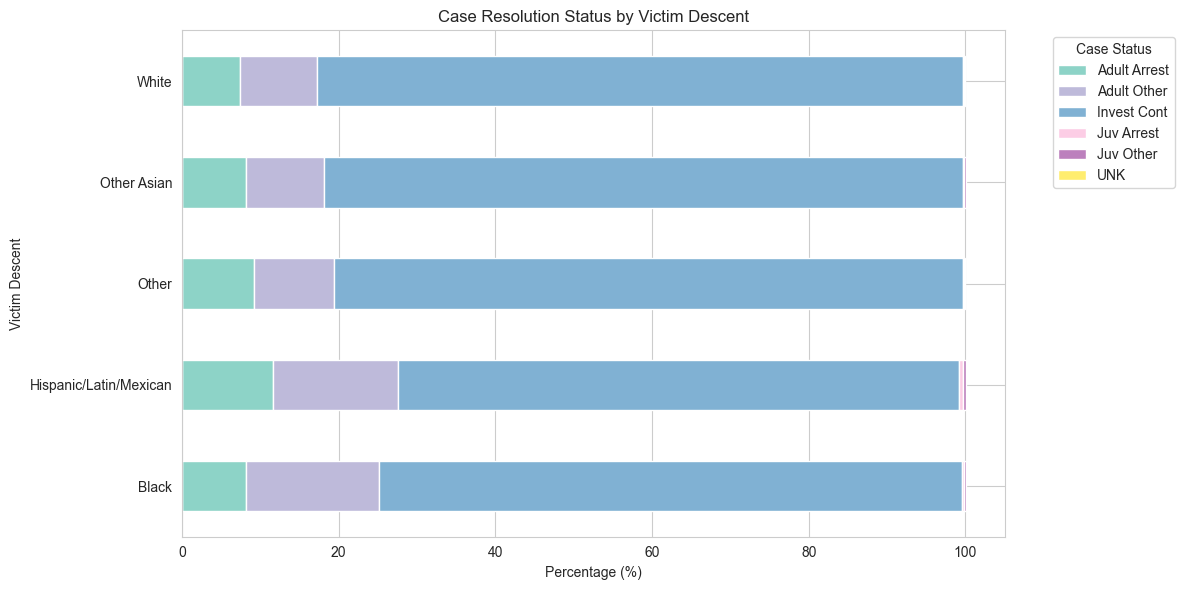

In [11]:
# Stacked bar chart of case status
status_by_descent.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='Set3')
plt.xlabel('Percentage (%)')
plt.ylabel('Victim Descent')
plt.title('Case Resolution Status by Victim Descent')
plt.legend(title='Case Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
# Chi-squared test: Is case status independent of victim descent?
contingency_table = pd.crosstab(df_top5['vict_descent_label'], df_top5['status_desc'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2:.2f}')
print(f'Degrees of freedom: {dof}')
print(f'P-value: {p_value:.6f}')

if p_value < 0.05:
    print('Result: The relationship between victim descent and case status is statistically significant (p < 0.05).')
    print('This suggests that case outcomes are not independent of the victim\'s racial/ethnic group.')
else:
    print('Result: No statistically significant relationship found between victim descent and case status.')

Chi-squared statistic: 10788.53
Degrees of freedom: 20
P-value: 0.000000
Result: The relationship between victim descent and case status is statistically significant (p < 0.05).
This suggests that case outcomes are not independent of the victim's racial/ethnic group.


## 5. Victimization Rate by Age and Descent

We analyze the age distribution of victims across racial groups. Systematic differences may point to differential exposure to crime or differential reporting patterns.

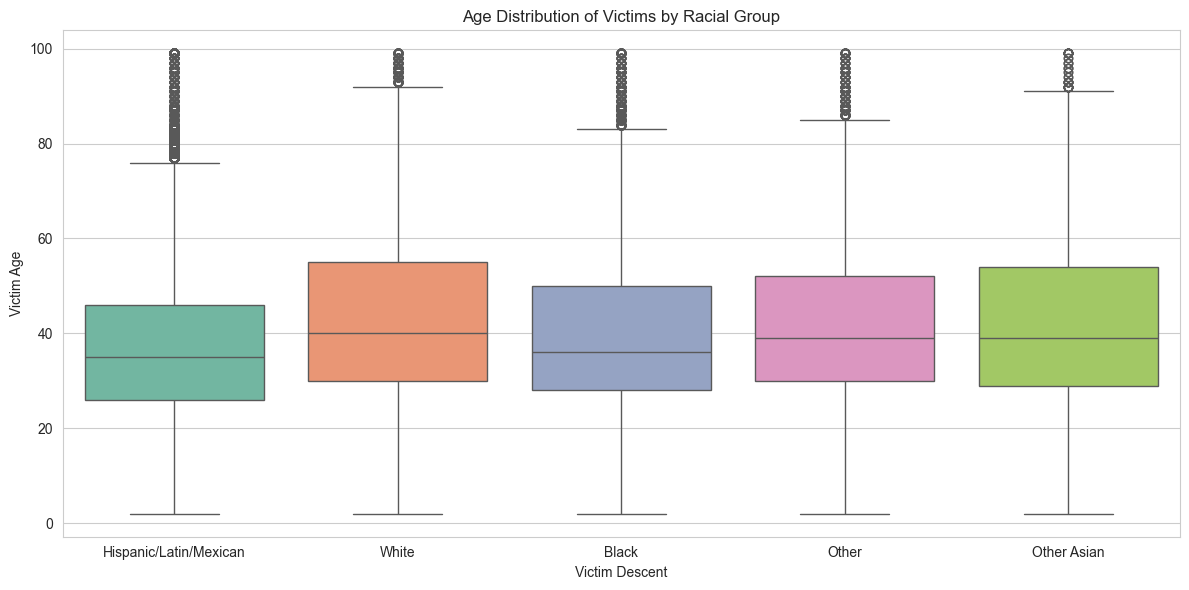

In [13]:
# Filter out invalid ages (negative or extremely high)
df_age = df_top5[(df_top5['vict_age'] > 0) & (df_top5['vict_age'] < 100)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_age, x='vict_descent_label', y='vict_age', palette='Set2',
            order=top_5_groups)
plt.xlabel('Victim Descent')
plt.ylabel('Victim Age')
plt.title('Age Distribution of Victims by Racial Group')
plt.tight_layout()
plt.show()

In [14]:
# Summary statistics of victim age per descent group
age_stats = df_age.groupby('vict_descent_label')['vict_age'].describe().round(1)
age_stats = age_stats.loc[top_5_groups]
age_stats

,count,mean,std,min,25%,50%,75%,max
vict_descent_label,,,,,,,,
Hispanic/Latin/Mexican,291499.0,36.9,14.6,2.0,26.0,35.0,46.0,99.0
White,186518.0,43.5,16.3,2.0,30.0,40.0,55.0,99.0
Black,134248.0,39.4,15.4,2.0,28.0,36.0,50.0,99.0
Other,64599.0,41.8,15.4,2.0,30.0,39.0,52.0,99.0
Other Asian,21000.0,42.3,16.7,2.0,29.0,39.0,54.0,99.0


## 6. Geographic Concentration: Are Certain Groups Overrepresented in Specific Areas?

If crime victims of a particular descent are concentrated in certain areas, it could reflect residential segregation, targeted policing, or socioeconomic inequality. We compare the geographic distribution across groups.

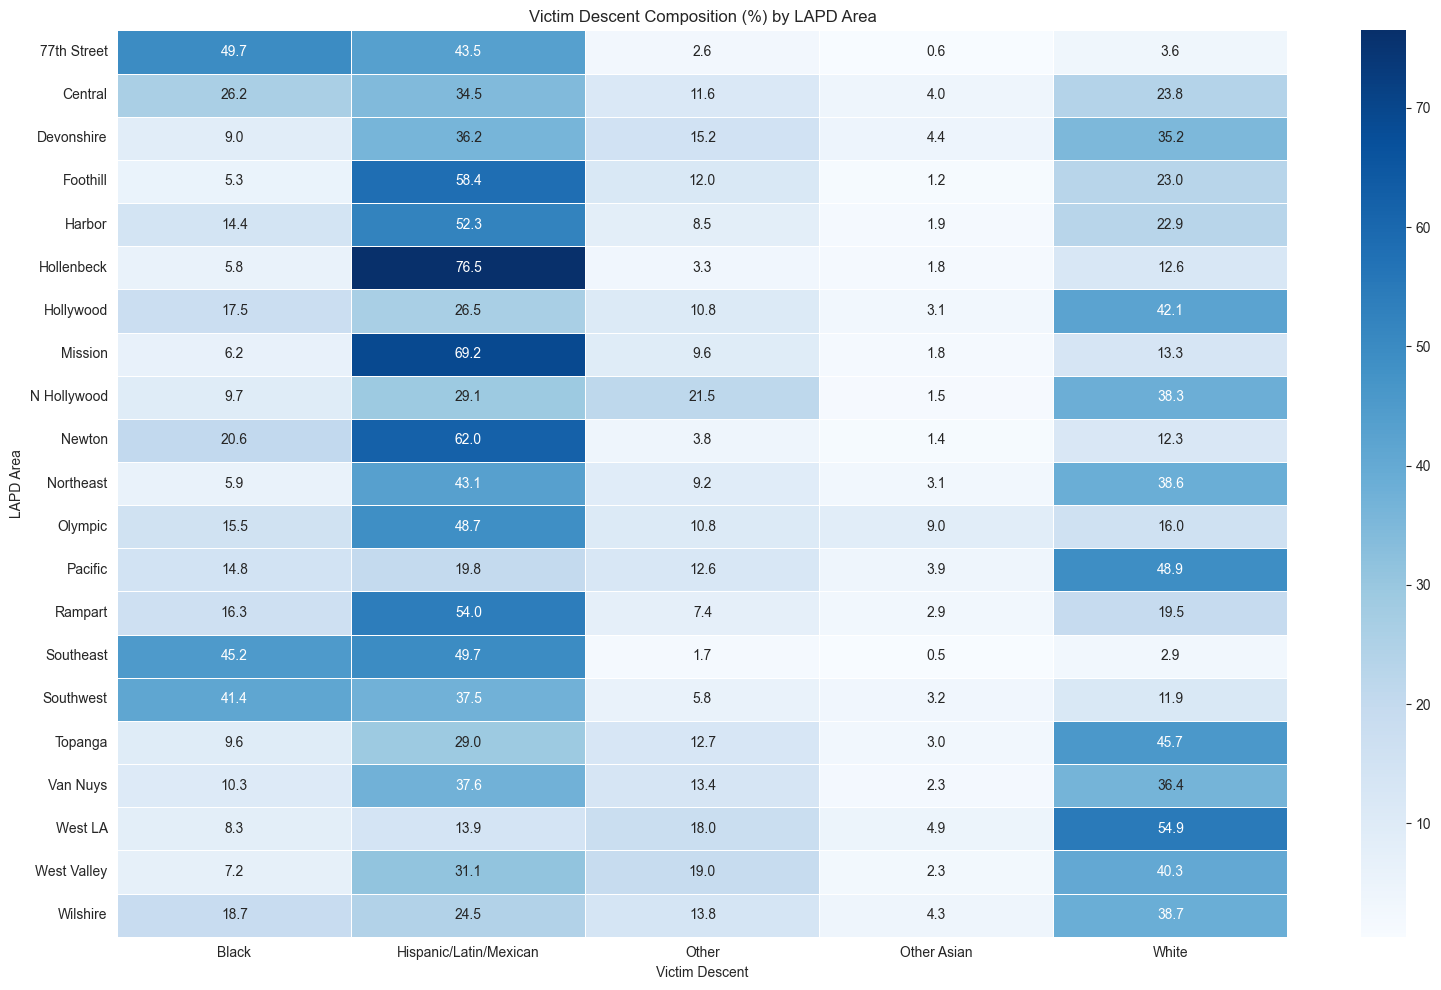

In [15]:
# Distribution of top 5 descent groups across LAPD areas
area_descent = df_top5.groupby(['area_name', 'vict_descent_label']).size().unstack(fill_value=0)

# Normalize per area to see the racial composition of victims in each area
area_descent_pct = area_descent.div(area_descent.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 10))
sns.heatmap(area_descent_pct, annot=True, fmt='.1f', cmap='Blues', linewidths=0.5)
plt.title('Victim Descent Composition (%) by LAPD Area')
plt.xlabel('Victim Descent')
plt.ylabel('LAPD Area')
plt.tight_layout()
plt.show()

In [16]:
# Identify areas with extreme racial concentration (> 60% of victims from one group)
threshold = 60
high_concentration = area_descent_pct[area_descent_pct > threshold].stack().reset_index()
high_concentration.columns = ['area_name', 'vict_descent_label', 'percentage']
high_concentration = high_concentration.sort_values('percentage', ascending=False)

print(f'Areas where a single descent group represents more than {threshold}% of victims:')
high_concentration

Areas where a single descent group represents more than 60% of victims:


,area_name,vict_descent_label,percentage
0,Hollenbeck,Hispanic/Latin/Mexican,76.498557
1,Mission,Hispanic/Latin/Mexican,69.165870
2,Newton,Hispanic/Latin/Mexican,61.962322


## 7. Weapon Usage in Crimes by Victim Descent

We explore whether crimes involving weapons differ by victim descent. This can reveal patterns in the severity of crimes reported against different groups.

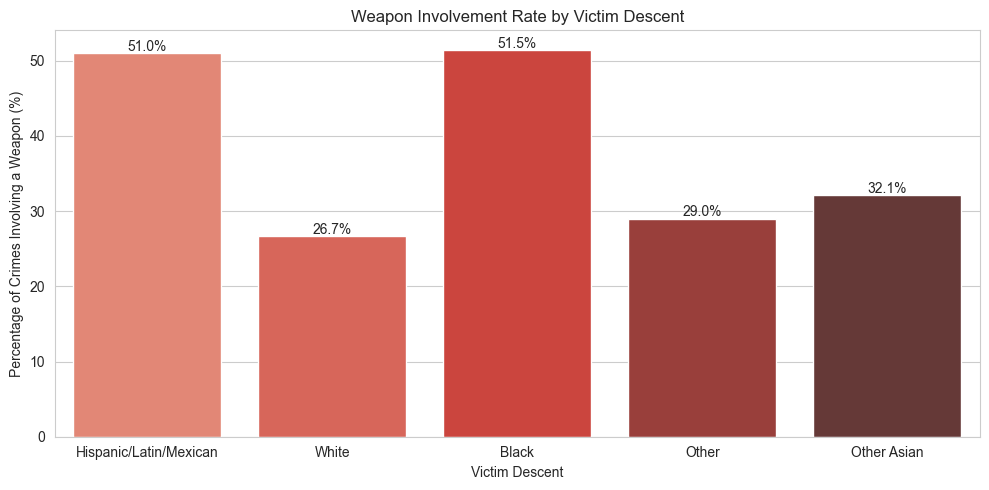

In [17]:
# Flag whether a weapon was used
df_top5['weapon_used'] = df_top5['weapon_used_cd'].notna()

weapon_rate = df_top5.groupby('vict_descent_label')['weapon_used'].mean() * 100
weapon_rate = weapon_rate.reindex(top_5_groups).round(2)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=weapon_rate.index, y=weapon_rate.values, palette='Reds_d')
plt.xlabel('Victim Descent')
plt.ylabel('Percentage of Crimes Involving a Weapon (%)')
plt.title('Weapon Involvement Rate by Victim Descent')

for i, v in enumerate(weapon_rate.values):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
# Top weapon types per descent group (among crimes where a weapon was used)
df_weapons = df_top5[df_top5['weapon_used']].copy()

for group in top_5_groups:
    group_weapons = df_weapons[df_weapons['vict_descent_label'] == group]['weapon_desc'].value_counts().head(5)
    print(f'\nTop 5 weapons used in crimes against {group} victims:')
    for weapon, count in group_weapons.items():
        print(f'  {weapon}: {count}')


Top 5 weapons used in crimes against Hispanic/Latin/Mexican victims:
  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE): 86127
  UNKNOWN WEAPON/OTHER WEAPON: 12908
  VERBAL THREAT: 9992
  HAND GUN: 9288
  KNIFE WITH BLADE 6INCHES OR LESS: 3498

Top 5 weapons used in crimes against White victims:
  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE): 29719
  UNKNOWN WEAPON/OTHER WEAPON: 8029
  VERBAL THREAT: 4483
  HAND GUN: 2048
  KNIFE WITH BLADE 6INCHES OR LESS: 935

Top 5 weapons used in crimes against Black victims:
  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE): 35775
  UNKNOWN WEAPON/OTHER WEAPON: 6423
  VERBAL THREAT: 5344
  HAND GUN: 5021
  UNKNOWN FIREARM: 2124

Top 5 weapons used in crimes against Other victims:
  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE): 11461
  UNKNOWN WEAPON/OTHER WEAPON: 3572
  VERBAL THREAT: 2128
  HAND GUN: 1300
  KNIFE WITH BLADE 6INCHES OR LESS: 422

Top 5 weapons used in crimes against Other Asian victims:
  STRONG-ARM (HANDS, FIST, FEET OR BODILY 

## 8. Temporal Evolution of Victimization by Descent

Has the proportion of victims from each racial group changed over time? Shifts could indicate changing policing practices, demographic changes, or evolving social conditions.

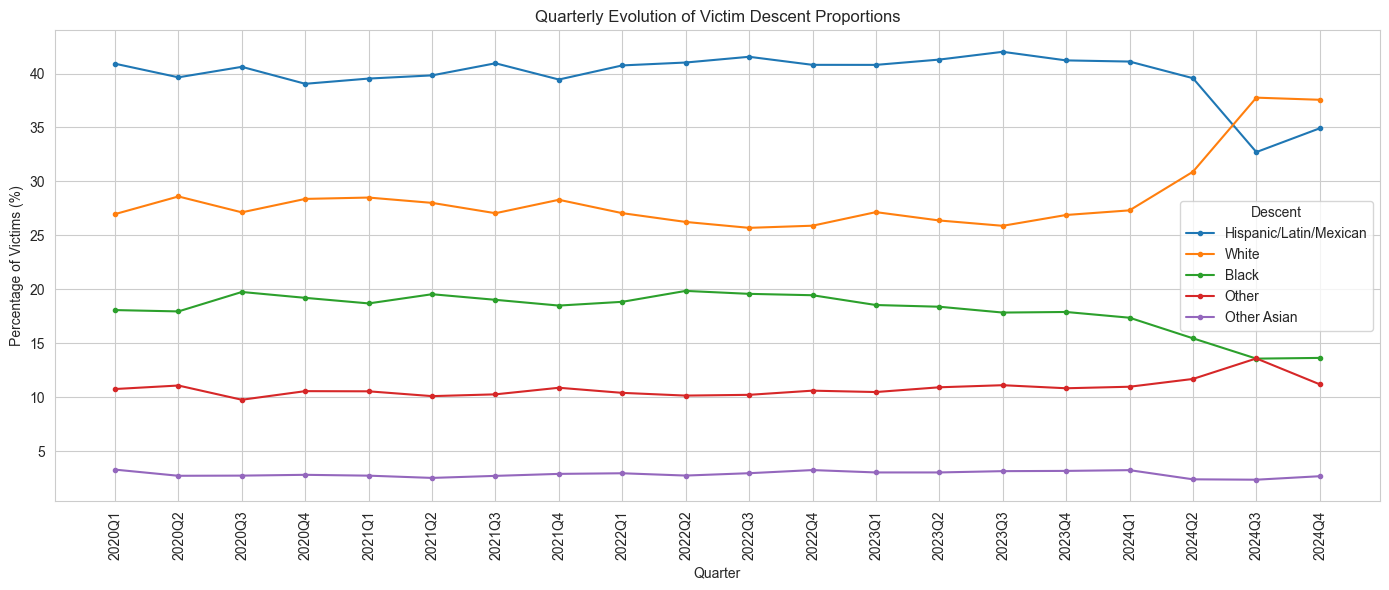

In [19]:
# Monthly victim proportion by descent group
df_top5['year_month'] = df_top5['date_occ'].dt.to_period('Q')  # quarterly for cleaner trend

quarterly_descent = df_top5.groupby(['year_month', 'vict_descent_label']).size().unstack(fill_value=0)
quarterly_descent_pct = quarterly_descent.div(quarterly_descent.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 6))
for group in top_5_groups:
    plt.plot(quarterly_descent_pct.index.astype(str), quarterly_descent_pct[group], marker='.', label=group)

plt.xlabel('Quarter')
plt.ylabel('Percentage of Victims (%)')
plt.title('Quarterly Evolution of Victim Descent Proportions')
plt.xticks(rotation=90)
plt.legend(title='Descent')
plt.tight_layout()
plt.show()

## 9. Victim Sex Distribution Across Racial Groups

We check if the gender distribution of victims varies by descent. Significant differences could indicate intersectional patterns in crime victimization.

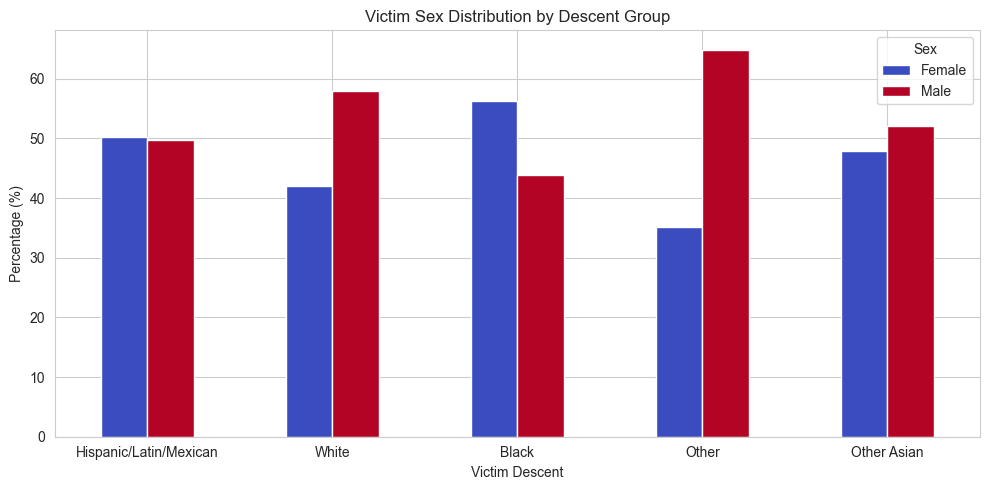

Victim sex distribution (%) by descent group:


vict_sex,F,M
vict_descent_label,,
Hispanic/Latin/Mexican,50.22,49.78
White,42.07,57.93
Black,56.20,43.80
Other,35.13,64.87
Other Asian,47.96,52.04


In [20]:
# Filter to known sex values
df_sex = df_top5[df_top5['vict_sex'].isin(['M', 'F'])].copy()

sex_by_descent = df_sex.groupby('vict_descent_label')['vict_sex'].value_counts(normalize=True).unstack(fill_value=0) * 100
sex_by_descent = sex_by_descent.reindex(top_5_groups).round(2)

sex_by_descent.plot(kind='bar', figsize=(10, 5), colormap='coolwarm')
plt.xlabel('Victim Descent')
plt.ylabel('Percentage (%)')
plt.title('Victim Sex Distribution by Descent Group')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print('Victim sex distribution (%) by descent group:')
sex_by_descent

## 10. Disproportionality Index

We compute a simple disproportionality index that compares each group's share of crime victims with their estimated share of the LA population. A value above 1.0 means the group is overrepresented as victims; below 1.0 means underrepresented.

Population estimates for Los Angeles (approximate, from US Census data):
- Hispanic/Latin/Mexican: 48.0%
- White: 28.9%
- Black: 8.3%
- Other Asian (aggregated): 11.7%
- Other: 3.1%

These are rough estimates and should be refined for a rigorous study.

In [21]:
# Approximate LA population share (these should be updated with official census data)
la_population_share = {
    'Hispanic/Latin/Mexican': 48.0,
    'White': 28.9,
    'Black': 8.3,
    'Other Asian': 11.7,
    'Other': 3.1
}

# Victim share in dataset
victim_share = df_top5['vict_descent_label'].value_counts(normalize=True) * 100

disproportionality = pd.DataFrame({
    'victim_pct': [victim_share.get(g, 0) for g in la_population_share.keys()],
    'population_pct': list(la_population_share.values())
}, index=la_population_share.keys())

disproportionality['disproportionality_index'] = (
    disproportionality['victim_pct'] / disproportionality['population_pct']
).round(3)

disproportionality = disproportionality.round(2)

print('Disproportionality Index (victim share / population share):')
print('Values > 1.0 indicate overrepresentation as victims; < 1.0 underrepresentation.')
disproportionality

Disproportionality Index (victim share / population share):
Values > 1.0 indicate overrepresentation as victims; < 1.0 underrepresentation.


,victim_pct,population_pct,disproportionality_index
Hispanic/Latin/Mexican,40.44,48.0,0.84
White,27.48,28.9,0.95
Black,18.53,8.3,2.23
Other Asian,2.91,11.7,0.25
Other,10.64,3.1,3.43


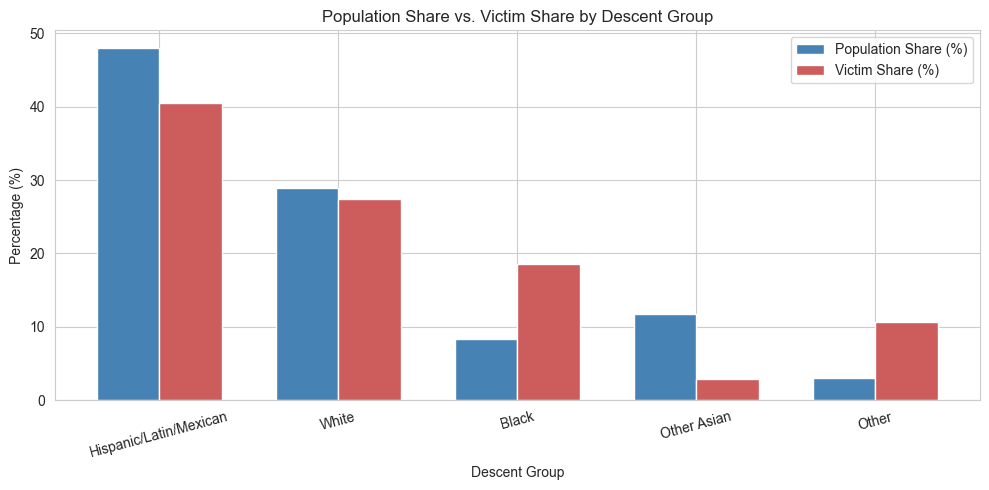

In [22]:
# Visualize disproportionality
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(disproportionality))
width = 0.35

bars1 = ax.bar(x - width/2, disproportionality['population_pct'], width, label='Population Share (%)', color='steelblue')
bars2 = ax.bar(x + width/2, disproportionality['victim_pct'], width, label='Victim Share (%)', color='indianred')

ax.set_xlabel('Descent Group')
ax.set_ylabel('Percentage (%)')
ax.set_title('Population Share vs. Victim Share by Descent Group')
ax.set_xticks(x)
ax.set_xticklabels(disproportionality.index, rotation=15)
ax.legend()
plt.tight_layout()
plt.show()

## 11. Violent vs. Non-Violent Crime Distribution by Descent

We classify crimes as violent or non-violent based on common patterns in crime code descriptions, and compare the proportion across racial groups.

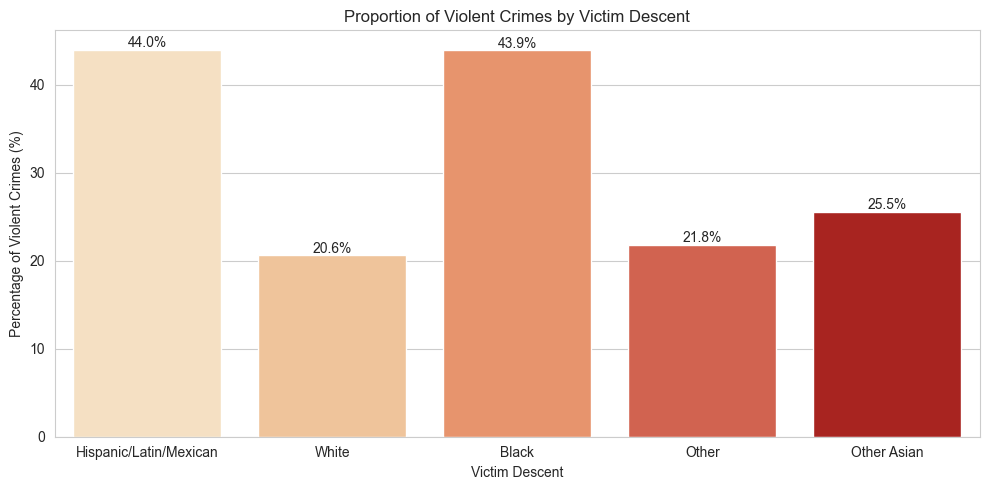

In [23]:
# Define a basic classification of violent crimes based on keywords in the crime description
violent_keywords = [
    'ASSAULT', 'ROBBERY', 'HOMICIDE', 'RAPE', 'KIDNAPPING',
    'BATTERY', 'SHOTS FIRED', 'MANSLAUGHTER', 'LYNCHING',
    'CHILD ABUSE', 'BRANDISH WEAPON', 'THREATENING'
]

df_top5['is_violent'] = df_top5['crm_cd_desc'].str.upper().apply(
    lambda x: any(kw in x for kw in violent_keywords) if pd.notna(x) else False
)

violent_rate = df_top5.groupby('vict_descent_label')['is_violent'].mean() * 100
violent_rate = violent_rate.reindex(top_5_groups).round(2)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=violent_rate.index, y=violent_rate.values, palette='OrRd')
plt.xlabel('Victim Descent')
plt.ylabel('Percentage of Violent Crimes (%)')
plt.title('Proportion of Violent Crimes by Victim Descent')

for i, v in enumerate(violent_rate.values):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 12. Area-Level Analysis: Crime Rates Per Descent in Specific Neighborhoods

We select two contrasting areas (one more homogeneous, one more diverse) and compare how crime profiles and descent distributions differ.

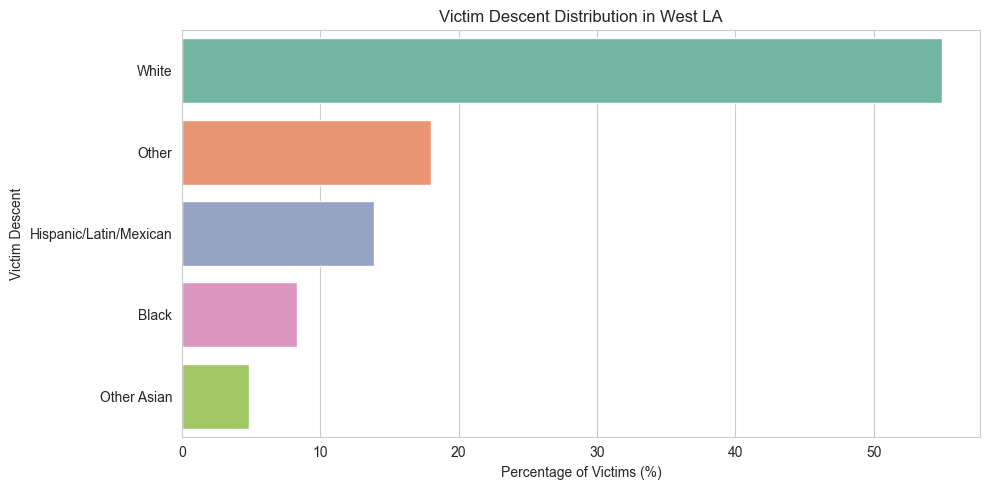

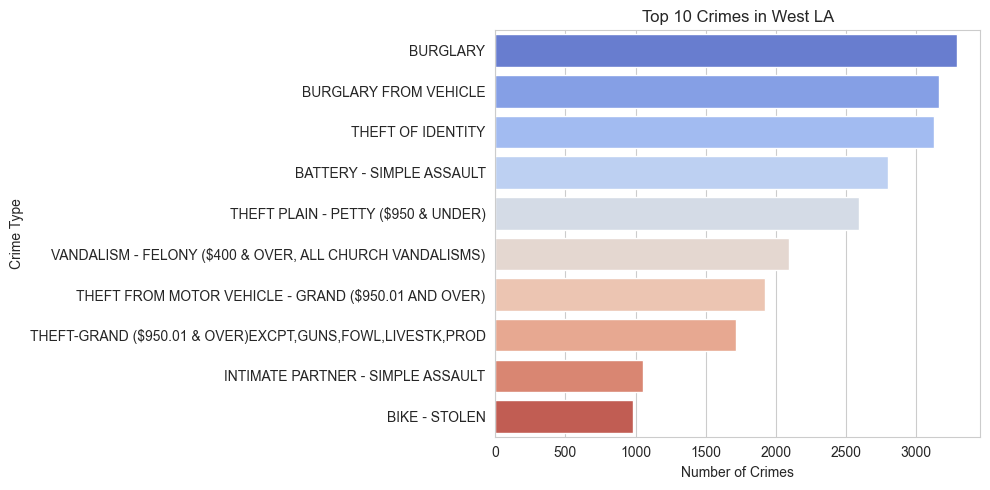

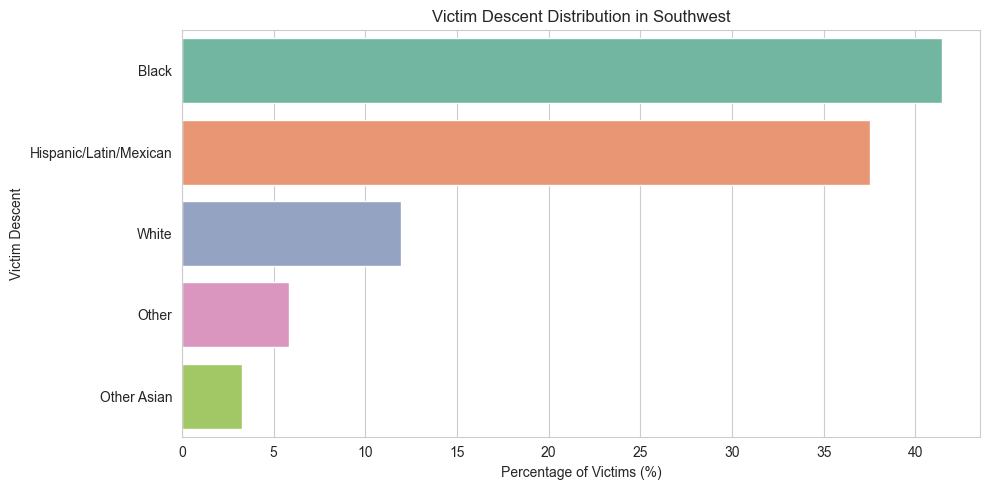

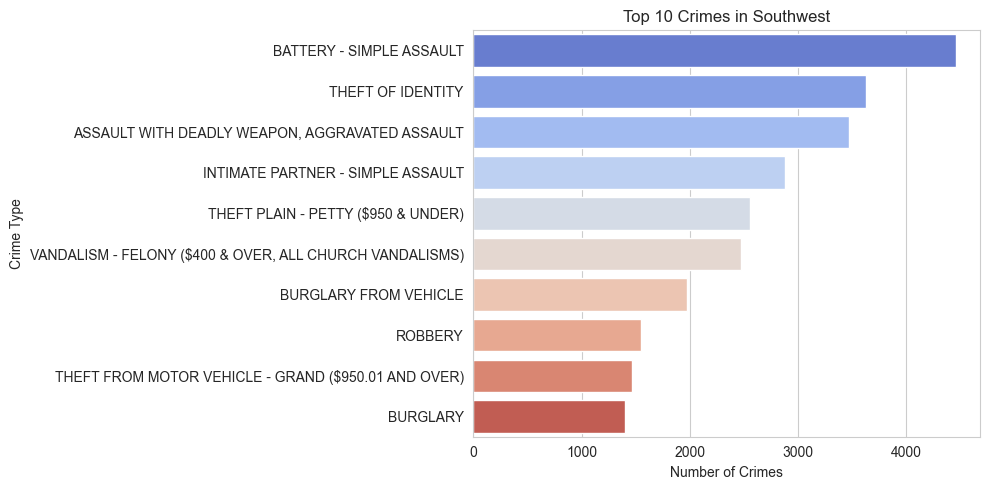

In [24]:
# Select two areas for comparison
area_1 = 'West LA'
area_2 = 'Southwest'

for area in [area_1, area_2]:
    area_df = df_top5[df_top5['area_name'] == area]
    descent_dist = area_df['vict_descent_label'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=descent_dist.values, y=descent_dist.index, palette='Set2')
    plt.xlabel('Percentage of Victims (%)')
    plt.ylabel('Victim Descent')
    plt.title(f'Victim Descent Distribution in {area}')
    plt.tight_layout()
    plt.show()
    
    top_crimes = area_df['crm_cd_desc'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_crimes.values, y=top_crimes.index, palette='coolwarm')
    plt.xlabel('Number of Crimes')
    plt.ylabel('Crime Type')
    plt.title(f'Top 10 Crimes in {area}')
    plt.tight_layout()
    plt.show()

## 13. Statistical Summary and Observations

This section consolidates the key metrics computed above.

In [25]:
# Consolidated summary table
summary = pd.DataFrame(index=top_5_groups)
summary['victim_count'] = descent_counts.reindex(top_5_groups)
summary['victim_pct'] = descent_pct.reindex(top_5_groups).round(2)
summary['violent_crime_pct'] = violent_rate
summary['weapon_involved_pct'] = weapon_rate

# Median victim age
median_age = df_age.groupby('vict_descent_label')['vict_age'].median()
summary['median_victim_age'] = median_age.reindex(top_5_groups)

print('Consolidated bias analysis summary for top 5 descent groups:')
summary

Consolidated bias analysis summary for top 5 descent groups:


,victim_count,victim_pct,violent_crime_pct,weapon_involved_pct,median_victim_age
Hispanic/Latin/Mexican,296365,39.33,43.96,51.03,35.0
White,201424,26.73,20.59,26.69,40.0
Black,135810,18.02,43.88,51.46,36.0
Other,77996,10.35,21.79,28.99,39.0
Other Asian,21336,2.83,25.53,32.09,39.0


In [26]:
# Kruskal-Wallis test: Do victim ages differ significantly across descent groups?
age_groups = [group['vict_age'].values for name, group in df_age.groupby('vict_descent_label') if name in top_5_groups]
h_stat, p_val = stats.kruskal(*age_groups)

print(f'Kruskal-Wallis H statistic (victim age across descent groups): {h_stat:.2f}')
print(f'P-value: {p_val:.6f}')
if p_val < 0.05:
    print('The differences in victim age distributions across racial groups are statistically significant.')
else:
    print('No statistically significant differences in victim age distributions across racial groups.')

Kruskal-Wallis H statistic (victim age across descent groups): 19519.91
P-value: 0.000000
The differences in victim age distributions across racial groups are statistically significant.


## Conclusiones y Limitaciones

Hallazgos clave de este análisis:

1. **Representación demográfica**: Las víctimas hispanas/latinas/mexicanas y negras están notablemente representadas en el conjunto de datos. El índice de desproporcionalidad ayuda a contextualizar si esto coincide con su proporción de población en LA.

2. **Diferencias en tipos de delitos**: Los tipos de delitos reportados varían entre grupos raciales. Algunos grupos enfrentan mayores proporciones de delitos violentos, lo cual puede reflejar condiciones socioeconómicas, patrones de vigilancia policial o sesgos en los reportes.

3. **Resolución de casos**: La prueba de chi-cuadrado revela si los resultados de los casos son independientes del origen de la víctima. Un resultado significativo amerita una investigación más profunda sobre cómo pueden diferir los procesos de resolución de casos.

4. **Concentración geográfica**: Ciertas áreas del LAPD muestran una fuerte concentración de grupos específicos de origen entre las víctimas, reflejando la segregación residencial de Los Ángeles.

5. **Uso de armas**: Las diferencias en las tasas de uso de armas entre grupos de origen sugieren que la gravedad de los delitos no se distribuye uniformemente.

**Limitaciones**:
- Este conjunto de datos solo refleja delitos reportados. Los delitos no reportados, que también pueden seguir patrones raciales, no están capturados.
- Las estimaciones de población utilizadas para el índice de desproporcionalidad son aproximadas. Un análisis adecuado usaría datos demográficos a nivel de sección censal.
- La correlación no es causalidad. Los patrones encontrados aquí requieren interpretación contextual considerando factores socioeconómicos, políticas de vigilancia policial y desigualdades sistémicas.
- El campo 'vict_descent' registra el origen de la víctima, no el del sospechoso. El sesgo en la vigilancia policial también podría manifestarse en la identificación de sospechosos, lo cual estos datos no capturan completamente.